In [25]:
from PIL import Image
import numpy as np
import os
from random import shuffle
import matplotlib.pyplot as plt

DIR = 'C:\Yelp\Train'

# Want to know how we should format the height x width image data dimensions
# for inputting to a keras model
def get_size_statistics():
    heights = []
    widths = []
    img_count = 0
    for img in os.listdir(DIR):
        path = os.path.join(DIR, img)
        if "DS_Store" not in path:
            data = np.array(Image.open(path))
            heights.append(data.shape[0])
            widths.append(data.shape[1])
            img_count += 1
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))
get_size_statistics()

Average Height: 383.958217270195
Max Height: 400
Min Height: 150


Average Width: 482.1309192200557
Max Width: 600
Min Width: 200


In [26]:
def label_img(name):
    word_label = name.split('-')[0]
    if word_label == 'Burger':  return 1
    elif word_label =='Pizza': return 2
    elif word_label =='Chicken': return 3
    elif word_label =='Drink': return 4
    elif word_label =='Sweet': return 5
    elif word_label =='Tacos': return 6

In [27]:
IMG_SIZE = 256

def load_training_data():
    train_data = []
    for img in os.listdir(DIR):
        label = label_img(img)
        path = os.path.join(DIR, img)
        if "DS_Store" not in path:
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            train_data.append([np.array(img), label])
    shuffle(train_data)
    return train_data

In [28]:
train_data = np.array(load_training_data())
y=len(train_data)
X=[]
Y=[]

In [29]:
for i in range(y-1):
    img=np.array((train_data[i][0]).reshape(256,256))
    X.append(img)
    label=np.array(train_data[i][1])
    Y.append(label)
    #count=count+1
    #plt.imshow(some_image)
    #plt.show()

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    random_state=42,
                                                    test_size=0.20)

In [31]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(286, 256, 256)
(72, 256, 256)
(286,)
(72,)


In [33]:
X_train = X_train/255.
X_test = X_test/255.

X_train = X_train.reshape(-1, 65536)
X_test = X_test.reshape(-1, 65536)     

In [34]:
%pylab inline
import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K

from time import time
from sklearn.cluster import KMeans
from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from scipy.misc import imread
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

Populating the interactive namespace from numpy and matplotlib


C:\Users\udays\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'shuffle', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [35]:
# this is our input placeholder
input_img = Input(shape=(65536,))

# "encoded" is the encoded representation of the input
encoded = Dense(2000, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(500, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(2000, activation='relu')(decoded)
decoded = Dense(65536)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [36]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 65536)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 2000)              131074000 
_________________________________________________________________
dense_10 (Dense)             (None, 500)               1000500   
_________________________________________________________________
dense_11 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5010      
_________________________________________________________________
dense_13 (Dense)             (None, 500)               5500      
_________________________________________________________________
dense_14 (Dense)             (None, 500)               250500    
__________

In [37]:
#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [38]:
autoencoder.compile(optimizer='adam', loss='mse')

In [39]:
estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [40]:
train_history = autoencoder.fit(X_train,X_train, epochs=20, batch_size=50, validation_data=(X_test,X_test), callbacks=[estop])

Train on 286 samples, validate on 72 samples
Epoch 1/20
286/286 [==============================] - 60s 210ms/step - loss: 0.2721 - val_loss: 0.1058
Epoch 2/20
286/286 [==============================] - 28s 98ms/step - loss: 0.1070 - val_loss: 0.0971
Epoch 3/20
286/286 [==============================] - 27s 95ms/step - loss: 0.0983 - val_loss: 0.0818
Epoch 4/20
286/286 [==============================] - 27s 94ms/step - loss: 0.0839 - val_loss: 0.0794
Epoch 5/20
286/286 [==============================] - 27s 93ms/step - loss: 0.0820 - val_loss: 0.0822
Epoch 6/20
286/286 [==============================] - 26s 92ms/step - loss: 0.0787 - val_loss: 0.0809
Epoch 7/20
286/286 [==============================] - 27s 94ms/step - loss: 0.0777 - val_loss: 0.0802
Epoch 8/20
286/286 [==============================] - 27s 93ms/step - loss: 0.0779 - val_loss: 0.0793
Epoch 9/20
286/286 [==============================] - 27s 95ms/step - loss: 0.0773 - val_loss: 0.0801
Epoch 10/20
286/286 [===============

In [41]:
pred = autoencoder.predict(X_test)

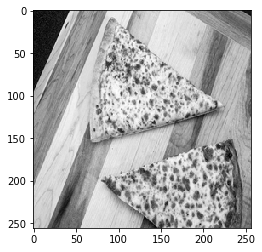

In [46]:
plt.imshow(X_test[0].reshape(256, 256), cmap='gray')

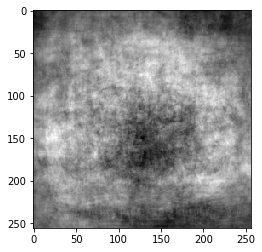

In [47]:
plt.imshow(pred[0].reshape(256,256), cmap='gray')